1. Introduction et Objectifs
Dans les notebooks précédents (04 et 05), nous avons utilisé une approche de type KNN (K-Nearest Neighbors). Le KNN est un algorithme de "Lazy Learning" qui ne crée pas de modèle global mais cherche simplement les voisins les plus proches.

L'objectif de ce notebook : Passer à une approche de Machine Learning Supervisé en utilisant une Forêt Aléatoire (Random Forest).

Contrairement au KNN, la Forêt Aléatoire va apprendre les relations complexes entre les caractéristiques (genres, synopsis, popularité) et la note cible (score).

Cela nous permettra d'identifier quels critères (features) sont les plus déterminants pour le succès d'un anime.

2. Imports et Configuration

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# Prétraitement et Features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from scipy import sparse
import ast

# Modèle et Évaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configuration
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")


3. Chargement et Inspection des Données

In [10]:
# Chargement du dataset nettoyé
DATA_PATH = "../data/processed/anime_master_clean.csv"
df = pd.read_csv(DATA_PATH)

print(f"Dimensions du dataset : {df.shape}")

# Nettoyage rapide pour l'entraînement
# On retire les animes sans synopsis ou sans score (notre cible)
df = df.dropna(subset=['synopsis', 'score'])
df = df.reset_index(drop=True)

# Conversion de la colonne genres de string vers liste
def convert_to_list(x):
    if isinstance(x, str):
        try: return ast.literal_eval(x)
        except: return []
    return x

df['genres_list'] = df['genres_list'].apply(convert_to_list)

df.head(3)

Dimensions du dataset : (28953, 23)


,mal_id,title,title_norm,type,rating,year,genres_list,genres_str,genres_count,themes_list,themes_str,themes_count,synopsis,synopsis_length,score,weighted_score,members,popularity,completion_rate,drop_rate,fav_count,image_url,studios
0,56036,......,......,Music,PG-13 - Teens 13 or older,NaN,"[Horror, Supernatural]","Horror, Supernatural",2,['Music'],Music,1,Music video directed by obmolot for the song ....,11,6.53,6.53,941,15004,0.818278,0.030818,1,NaN,NaN
1,2928,.hack//G.U. Returner,.hack//g.u. returner,OVA,PG-13 - Teens 13 or older,NaN,"[Adventure, Drama, Fantasy]","Adventure, Drama, Fantasy",3,['Video Game'],Video Game,1,The characters from previous .hack//G.U. Games...,70,6.65,6.65,22525,5056,0.663781,0.015493,1,NaN,NaN
2,3269,.hack//G.U. Trilogy,.hack//g.u. trilogy,Movie,PG-13 - Teens 13 or older,NaN,"[Action, Fantasy]","Action, Fantasy",2,['Video Game'],Video Game,1,"Based on the CyberConnect2 HIT GAME, now will ...",228,7.06,7.06,34264,4215,0.665071,0.015671,5,NaN,NaN


4. Feature Engineering (Pipeline de Données)
Nous allons construire une matrice de caractéristiques similaire à celle du modèle "Light", mais optimisée pour un régresseur.

In [11]:
print("--- Extraction des caractéristiques ---")

# A. Analyse Textuelle (TF-IDF)
# On limite à 2000 features pour éviter l'explosion de la mémoire avec RF
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['synopsis'])
print(f"Matrice TF-IDF : {tfidf_matrix.shape}")

# B. Encodage des Genres (MultiLabelBinarizer)
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])
print(f"Matrice Genres : {genre_encoded.shape}")

# C. Caractéristiques Numériques
# On inclut la popularité et le nombre de membres car ils corrèlent souvent avec le score
num_cols = ['members', 'popularity', 'year']
df[num_cols] = df[num_cols].fillna(0)
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(df[num_cols])

# D. Concaténation finale
X = sparse.hstack([
    tfidf_matrix, 
    sparse.csr_matrix(genre_encoded), 
    sparse.csr_matrix(num_scaled)
]).tocsr()

y = df['score']

print(f"Format final de la matrice X : {X.shape}")

--- Extraction des caractéristiques ---
Matrice TF-IDF : (18266, 2000)
Matrice Genres : (18266, 21)
Format final de la matrice X : (18266, 2024)


5. Entraînement du Modèle Random Forest

In [12]:
# Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Entraînement du RandomForestRegressor...")
# Paramètres optimisés pour un bon compromis temps/précision
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15, 
    n_jobs=-1, 
    random_state=42,
    verbose=1
)

rf_model.fit(X_train, y_train)

Entraînement du RandomForestRegressor...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished


,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


6. Analyse des Performances et Visualisation

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



--- RÉSULTATS DU MODÈLE ---
RMSE : 0.5624
MAE  : 0.4193
R2   : 0.6019


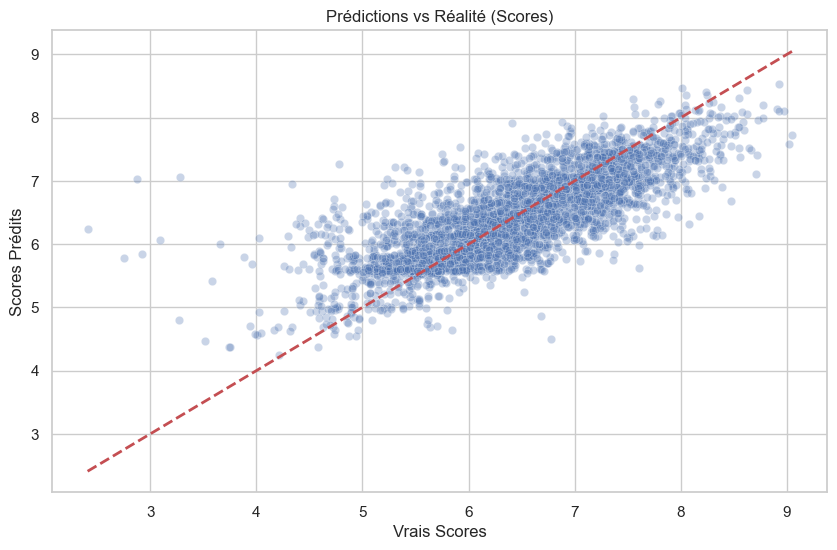

In [13]:
# Prédictions
y_pred = rf_model.predict(X_test)

# Métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- RÉSULTATS DU MODÈLE ---")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R2   : {r2:.4f}")

# Visualisation des prédictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.title("Prédictions vs Réalité (Scores)")
plt.xlabel("Vrais Scores")
plt.ylabel("Scores Prédits")
plt.show()

7. Importance des Caractéristiques (L'atout majeur)

C:\Users\benja\AppData\Local\Temp\ipykernel_17704\563142508.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


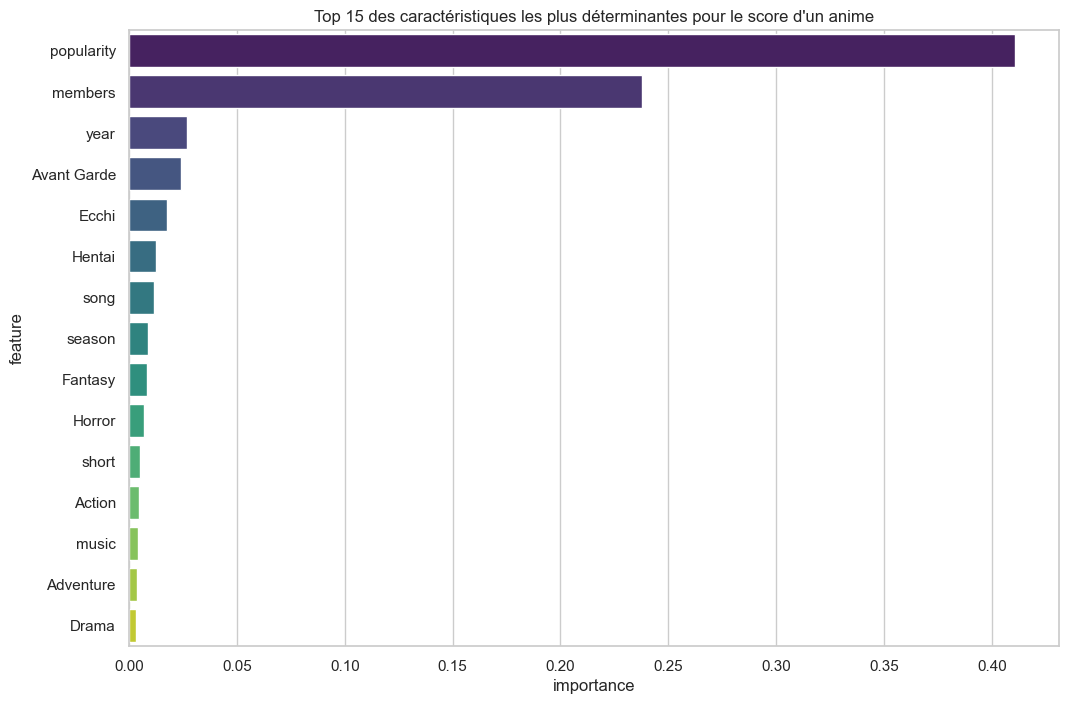

In [14]:
# Récupération des noms de colonnes
all_features = (
    list(tfidf.get_feature_names_out()) + 
    list(mlb.classes_) + 
    num_cols
)

importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
plt.title("Top 15 des caractéristiques les plus déterminantes pour le score d'un anime")
plt.show()

8. Sauvegarde des Artefacts

In [15]:
# Création du dossier de run
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"../runs/random_forest_{run_id}/artifacts/"
os.makedirs(save_dir, exist_ok=True)

# Sauvegarde
joblib.dump(rf_model, f"{save_dir}rf_model.joblib")
joblib.dump(tfidf, f"{save_dir}tfidf_vectorizer.joblib")
joblib.dump(mlb, f"{save_dir}genre_binarizer.joblib")
joblib.dump(scaler, f"{save_dir}scaler.joblib")

print(f"✅ Modèle et artefacts sauvegardés dans : {save_dir}")

✅ Modèle et artefacts sauvegardés dans : ../runs/random_forest_20251227_161917/artifacts/


9. Test du modèle : Système de Recommandation "RF-Rank"

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_final_fixed_recommendations(anime_title, n_recs=20):
    # 1. IDENTIFICATION INTELLIGENTE (Éviter les spin-offs comme Koisuru)
    # On cherche tous les animes qui contiennent le nom
    all_matches = df[df['title'].str.contains(anime_title, case=False, na=False)]
    
    if all_matches.empty: return "Anime non trouvé."
    
    # Stratégie : On prend celui qui a le nom EXACT ou le plus de MEMBRES (le plus connu)
    exact_match = all_matches[all_matches['title'].str.lower() == anime_title.lower()]
    
    if not exact_match.empty:
        target_idx = exact_match.index[0]
    else:
        # Si pas de match exact, on prend le plus populaire du groupe
        target_idx = all_matches.sort_values(by='members', ascending=False).index[0]
    
    target_anime = df.loc[target_idx]
    target_genres = set(target_anime['genres_list'])
    
    print(f"✅ Cible identifiée : {target_anime['title']} (Index: {target_idx})")
    print(f"📊 Popularité : {target_anime['members']} membres")
    print(f"🧬 Genres : {target_genres}")
    print("-" * 30)

    # 2. FILTRAGE DE VETO (Basé sur l'ADN de l'anime trouvé)
    def strict_genre_filter(g_list):
        g_set = set(g_list)
        intersection = target_genres.intersection(g_set)
        # Score de Jaccard
        return len(intersection) / len(target_genres.union(g_set))

    df['temp_match_score'] = df['genres_list'].apply(strict_genre_filter)
    
    # Exclusion de l'original par INDEX pour éviter Naruto dans Naruto
    candidates = df[(df['temp_match_score'] > 0) & (df.index != target_idx)].copy()

    # 3. RANKING
    candidate_indices = candidates.index
    X_candidates = X[candidate_indices]
    X_target = X[target_idx]

    text_sim = cosine_similarity(X_target, X_candidates).flatten()
    rf_preds = rf_model.predict(X_candidates)
    rf_norm = (rf_preds - rf_preds.min()) / (rf_preds.max() - rf_preds.min() + 1e-9)

    # 4. SCORE FINAL
    candidates['final_score'] = (candidates['temp_match_score'] * 0.5) + \
                                (text_sim * 0.3) + \
                                (rf_norm * 0.2)

    return candidates.sort_values(by='final_score', ascending=False).head(n_recs)[['title', 'genres_list', 'score', 'final_score']]

# --- RE-TEST ---
print("--- TEST ONE PIECE ---")
display(get_final_fixed_recommendations("Naruto", n_recs=20))

--- TEST ONE PIECE ---
✅ Cible identifiée : Naruto (Index: 10952)
📊 Popularité : 3035328 membres
🧬 Genres : {'Fantasy', 'Action', 'Adventure'}
------------------------------


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


,title,genres_list,score,final_score
6330,Hunter x Hunter (2011),"[Action, Adventure, Fantasy]",9.03,0.939471
10963,Naruto: Shippuuden,"[Action, Adventure, Fantasy]",8.28,0.938610
11638,One Piece,"[Action, Adventure, Fantasy]",8.73,0.930489
11857,Ore dake Level Up na Ken Season 2: Arise from ...,"[Action, Adventure, Fantasy]",8.64,0.913700
3978,Fairy Tail,"[Action, Adventure, Fantasy]",7.57,0.910430
11856,Ore dake Level Up na Ken,"[Action, Adventure, Fantasy]",8.23,0.909388
3480,Dororo,"[Action, Adventure, Fantasy]",8.26,0.908167
12054,Overlord,"[Action, Adventure, Fantasy]",7.90,0.906044
10894,Nanatsu no Taizai,"[Action, Adventure, Fantasy]",7.61,0.901560
3700,Dungeon ni Deai wo Motomeru no wa Machigatteir...,"[Action, Adventure, Fantasy]",7.53,0.900997
